<a href="https://colab.research.google.com/github/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/blob/main/TareaSemana2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![MAIA banner](https://raw.githubusercontent.com/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/main/Images/Aprendizaje_refuerzo_profundo_Banner_V1.png)

# <h1><center>Tarea Tutorial - Semana 2 <a href="https://colab.research.google.com/github/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/blob/main/TareaSemana2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

<center><h1>Predicción y Control On-Policy</h1></center>

En este notebook tutorial vas a aprender sobre algunas técnicas <i>on-policy</i> que existen para aproximar la función de valor en un problema de aprendizaje por refuerzo y algoritmos de aprendizaje on-policy. Mostraremos el funcionamiento de estas técnicas y algoritmos utilizando el ambiente de <a href="https://gymnasium.farama.org/environments/classic_control/mountain_car/">Mountain Car</a>, incluido en las librerías de Gym. La misión central de este notebook es evidenciar de forma visual cómo se puede representar matemáticamente un problema y cómo se estructura una solución cuando se utilizan técnicas <i>on-policy</i>. El tutorial se divide en:


# Tabla de Contenidos
1. [Objetivos de Aprendizaje](#scrollTo=Objetivos_de_Aprendizaje)  
2. [Marco Teórico](#scrollTo=Marco_Te_rico)  
3. [Instalación de Librerías](#scrollTo=Instalaci_n_de_Librer_as)  
4. [Familiarización con el Entorno de Gym](#scrollTo=Familiarizaci_n_con_el_Entorno_de_Gym)  
5. [Predicción on-policy](#scrollTo=Predicci_n_on_policy)  
6. [Control on-policy](#scrollTo=Control_on_policy)  
7. [Reflexiones Finales](#scrollTo=Reflexiones_Finales)  
8. [Referencias](#scrollTo=Referencias)

# Objetivos de Aprendizaje  
  
* Conocer algunas formas matemáticas que se utilizan para representar problemas complejos de aprendizaje por refuerzo.
* Familiarizarse con los entornos de simulación de Gym.
* Entrenar y validar algoritmos de aprendizaje por refuerzo <i>on-policy</i> con aproximación de funciones (Deep SARSA).



# Marco Teórico  

_-_

_-_

_-_

_-_


Ahora, es necesario redirigir estos conceptos detrás de la aproximación de una función de valor al problema de control de política, es decir, al aprendizaje. Primero, recordemos que en el proceso de control de política un algoritmo busca construir una aproximación de la función de valor de acción $\hat{q}(s,a,\mathbf{w}) \approx q_*(s,a)$, donde $\mathbf{w}$ es un vector de tamaño finito con los pesos que definen la aproximación que se utilice. [1]

Para el caso de tareas episódicas, la extensión de los métodos de predicción de semi-gradiente a las funciones de valor de acciones es directa: $\hat{q}(s,a,\mathbf{w}) \approx q_{\pi}(s,a)$. Después, si se acoplan esas predicciones con técnicas de mejoramiento de política y selección de acciones, obtenemos el control de política. En tareas con un espacio de acciones discreto y relativamente pequeño, para cada posible acción $a$ posible en el siguiente estado $S_{t+1}$, se puede calcular $\hat{q}(S_{t+1},a,\mathbf{w}_t) \approx q_{\pi}(s,a)$ y encontrar la acción <i>greedy</i> ($A^*_{t+1} = \text{arg max}_a
 \hat{q}(s,a,\mathbf{w}))$. Para <i>algoritmos on-policy</i>, la política se mejora cambiando la política de estimación a una aproximación <i>soft</i> (que puede escoger cualquier acción) de la política <i>greedy</i> (que únicamente escoge la mejor acción). [1]

 La siguiente es la regla de actualización de SARSA de un paso, y el pseudoalgoritmo correspondiente se muestra en la Figura 3:



 <center>  $\mathbf{w}_{t+1} = \mathbf{w}_{t+1} + \alpha [R_{t+1} + \gamma \hat{q}(S_{t+1},a,\mathbf{w}_t) - \hat{q}(S_{t+1},a,\mathbf{w}_t) ] \nabla \hat{q}(S_{t+1},a,\mathbf{w}_t)$  &emsp;&emsp;&emsp;$(1)$ </center>


![SARSAnn](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/SARSA_dF.png)


<center>Figura 3. Algoritmo de SARSA con aproximación de funciones para control de política.</center>


# Instalación de Librerías  

Ejecute los siguientes bloques de código para instalar e importar las librerías requeridas en el tutorial. Aquí se instalan versiones compatibles de <i>keras</i>, <i>tensorflow</i> y <i>Gymnasium</i> para poder realizar los entrenamientos de SARSA con redes neuronales. La primera ejecución puede demorar un par de minutos en finalizar. Si la segunda celda le da un error, pruebe volver a ejecutar la celda.

In [ ]:
#Instala librerías
!pip install gymnasium #entorno de simulación
!pip install renderlab #libtería para renderizar

#importa librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf #importa tensorflow
import renderlab #importa renderlab para videos
import gymnasium  #importa gymnasium

#limpia registros
from IPython.display import clear_output
clear_output()
print("Todas las librerías han sido descargadas correctamente.")

Todas las librerías han sido descargadas correctamente.


# Familiarización con el Entorno de Gym

El ambiente de Gym de <a href="https://gymnasium.farama.org/environments/classic_control/mountain_car/">Mountain Car</a> consiste de un carro atrapado en el fondo de un valle, y debe acelerar a la izquierda o a la derecha para intentar ganar el impulso suficiente para salir. Puede leer más detalladamente la documentación de este ambiente en los foros oficiales de Gymnasium.

![Observation_space_cartpole](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Observation_space_mountaincar.png)

<center>Figura 5. Espacio de observación del ambiente de <i>Mountain Car</i>. [3]</center>

El espacio de estados del ambiente está definido en 2 dimensiones continuas, que definen la posición en el eje x y la velocidad del vehículo. Los límites de ambas variables puede observarse en la Figura 5. Por otra parte, el espacio de acciones consiste simplemente en 3 acciones discretas y determinísticas:

*   0: Acelera a la izquierda
*   1: No acelera
*   2: Acelera a la derecha

En este ambiente, el agente recibe una recompensa cuando alcanza una meta por fuera del valle, y por cada paso de tiempo que le toma alcanzarla recibe una recompensa negativa de -1. Si el auto llega a la meta (posición mayor a 0.5), el episodio se da por terminado, mientras que si el episodio supera los 200 pasos, se da por truncado; finalizando la simulación. Esto quiere decir que la peor recompensa posible será -200.


## Ejemplo

En esta sección se muestra un ejemplo de simulación de un episodio del <i>Mountain Car</i>. En este caso, el carro alterna acelerar a la izquierda y a la derecha en cada paso de tiempo.

In [ ]:
#Ejemplo de simulación de un episodio de Mountain Car
env_prueba_1 = gymnasium.make("MountainCar-v0", render_mode="rgb_array") #Se crea el ambiente. Para este tutorial, utilice gymnasium si va a renderizar.
env_prueba_1 = renderlab.RenderFrame(env_prueba_1, "./output") #Se crea una copia que se pueda renderizar con renderlab

obs , info = env_prueba_1.reset() #Se reinicia el estado para comenzar. En obs se almacena el estado observado (continuo, 2 dimensiones)
terminated = False #Inicializa una condición para el loop
truncated = False #Inicializa una condición para el loop
total_reward=0 #Inicializa contador del retorno
action=0 #Inicializamos una variable de acción para alternar la selección

while not (terminated or truncated): #Simula hasta que el carro salga del valle o hasta que pasen 200 episodios

  #Decide una acción. En este caso alterna entre izquierda y derecha
  if(action==0):
    action=2
  else:
    action=0

  obs, reward, terminated, truncated , info = env_prueba_1.step(action) #Con la función step el ambiente da un paso. Se obtiene el estado, recompensa y banderas de información
  total_reward+=reward #Llevamos una cuenta de la recompensa total

print("Recompensa obtenida en el episodio:",total_reward) #Se imprime la recompensa obtenida
print("\n\n")

env_prueba_1.play() #Con esta función se obtiene el video de la simulación

Recompensa obtenida en el episodio: -200.0



Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Puede observar que el retorno obtenido fue de -200, la peor recompensa posible. Alternar inmediatamente entre izquierda y derecha no es una estrategia útil.

## Ejercicio Práctico

Ahora, para comprobar el entendimiento y familiarización con el ambiente, intente por unos pocos minutos generar manualmente alguna estrategia para hacer que el carro logre salir del pozo (este será el problema que solucionaremos después con redes neuronales).

In [ ]:
# Genere alguna estrategia para intentar salir del pozo.

# =====================================================
# COMPLETAR ===========================================
#

# =====================================================

# Predicción on-policy




In [ ]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed.
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)),
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)

    def fullp (self):
        return len(self.dictionary) >= self.size

    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))



# Tile Coding Class
class MountainCarTileCoder:
    def __init__(self, iht_size=4096, num_tilings=8, num_tiles=8):
        """
        Initializes the MountainCar Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the
                     tile coder are the same
        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """
        self.iht = IHT(iht_size)
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles

    def get_tiles(self, position, velocity):
        """
        Takes in a position and velocity from the mountaincar environment
        and returns a numpy array of active tiles.

        Arguments:
        position -- float, the position of the agent between -1.2 and 0.5
        velocity -- float, the velocity of the agent between -0.07 and 0.07
        returns:
        array_tiles - np.array, active tiles
        """
        # Set the max and min of position and velocity to scale the input
        # The max position is set to 0.5 as this is the position to end the experiment
        POSITION_MIN = -1.2
        POSITION_MAX = 0.5
        VELOCITY_MIN = -0.07
        VELOCITY_MAX = 0.07

        # Scale position and velocity by multiplying the inputs of each by their scale
        position_scale = self.num_tiles / (POSITION_MAX - POSITION_MIN)
        velocity_scale = self.num_tiles / (VELOCITY_MAX - VELOCITY_MIN)

        # Obtain active tiles for current position and velocity
        array_tiles = tiles(self.iht, self.num_tilings, [position * position_scale, velocity * velocity_scale])

        return np.array(array_tiles)

In [ ]:
# Test the TileCoder class
mctc = MountainCarTileCoder(iht_size = 1024, num_tilings = 8, num_tiles = 8)
array_tiles = mctc.get_tiles(position = -1.0, velocity = 0.01)
# Tiles obtained at a random pos and vel
print("The Tiles obtained are: {0}\n".format(array_tiles))

The Tiles obtained are: [0 1 2 3 4 5 6 7]



# Control on-policy

En este apartado se busca comprender la construcción de arquitecturas de redes neuronales profundas y luego realizar un entrenamiento con el algoritmo <i>on-policy</i> de SARSA. Se va a revisar el efecto que tienen los cambios de hiperparámetros y se busca luego visualizar la función de valor discutida en la sección anterior.


## Ejemplo

En este apartado ...


In [ ]:
# SARSA
class SarsaAgent():
    """
    Initialization of Sarsa Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.last_action = None
        self.last_state = None
        self.epsilon = None
        self.gamma = None
        self.iht_size = None
        self.w = None
        self.alpha = None
        self.num_tilings = None
        self.num_tiles = None
        self.mctc = None
        self.initial_weights = None
        self.num_actions = None
        self.previous_tiles = None
        self.agent_init(agent_info_options)

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts."""
        self.num_tilings = agent_info.get("num_tilings", 8)
        self.num_tiles = agent_info.get("num_tiles", 8)
        self.iht_size = agent_info.get("iht_size", 4096)
        self.epsilon = agent_info.get("epsilon", 0.0)
        self.gamma = agent_info.get("gamma", 1.0)
        self.alpha = agent_info.get("alpha", 0.5) / self.num_tilings
        self.initial_weights = agent_info.get("initial_weights", 0.0)
        self.num_actions = agent_info.get("num_actions", 3)

        # Initialize self.w to three times the iht_size. Recall this is because
        # we need to have one set of weights for each action (Stacked values).
        self.w = np.ones((self.num_actions, self.iht_size)) * self.initial_weights

        # Initialize self.mctc to the mountaincar verions of the  tile coder created
        self.mctc = MountainCarTileCoder(iht_size = self.iht_size,
                                         num_tilings = self.num_tilings,
                                         num_tiles = self.num_tiles)

    def select_action(self, tiles):
        """
        Selects an action using epsilon greedy
        Args:
        tiles - np.array, an array of active tiles
        Returns:
        (chosen_action, action_value) - (int, float), tuple of the chosen action
                                        and it's value
        """
        action_values = []
        chosen_action = None

        # Obtain action values for all actions (sum through rows)
        action_values = np.sum(self.w[:, tiles], axis = 1)

        # Epsilon Greedy action selecion
        if np.random.random() < self.epsilon:
            # Select random action among the three posible actions
            chosen_action = np.random.randint(self.num_actions)
        else:
            # Select the greedy action
            chosen_action = np.argmax(action_values)

        return chosen_action, action_values[chosen_action]

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's env.reset() function.
        Returns:
            The first action the agent takes.
        """
        # Current state
        position, velocity = state

        # Obtain tiles activated at state cero
        active_tiles = self.mctc.get_tiles(position = position, velocity = velocity)
        # Select an action and obtain action values of the state
        current_action, action_value = self.select_action(active_tiles)

        # Save action as last action
        self.last_action = current_action
        # Save tiles as previous tiles
        self.previous_tiles = np.copy(active_tiles)

        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # Current state
        position, velocity = state

        # Compute current tiles
        active_tiles = self.mctc.get_tiles(position = position, velocity = velocity)
        # Obtain new action and action value before updating actition values
        current_action, action_value = self.select_action(active_tiles)

        # Update the Sarsa Target (delta)
        target = reward + (self.gamma * action_value)

        # Compute last action values to update weights
        last_action_val = np.sum(self.w[self.last_action][self.previous_tiles])

        # As we are using tile coding, which is a variant of linear function approximation
        # The gradient of the active tiles are one, otherwise cero.
        grad = 1
        self.w[self.last_action][self.previous_tiles] = self.w[self.last_action][self.previous_tiles] + \
            self.alpha * (target - last_action_val) * grad

        self.last_action = current_action
        self.previous_tiles = np.copy(active_tiles)
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        # There is no action_value used here because this is the end
        # of the episode.

        # Compute delta
        target = reward
        # Compute last action value
        last_action_val = np.sum(self.w[self.last_action][self.previous_tiles])
        grad = 1
        # Update weights
        self.w[self.last_action][self.previous_tiles] = self.w[self.last_action][self.previous_tiles] + \
            self.alpha * (target - last_action_val) * grad

    def return_action_value(self, state):
        """Run to obtain action-values for a given state.
        Args:
            state (Numpy array): the state observation
        Returns:
            The max action-value
        """

        # Current state
        position, velocity = state

        # Obtain tiles activated at state cero
        active_tiles = self.mctc.get_tiles(position = position, velocity = velocity)
        # Obtain action values for all actions (sum through rows)
        action_values = np.sum(self.w[:, active_tiles], axis = 1)
        # Obtain max action value
        max_action_value = np.max(action_values)

        return max_action_value

    def train(self, num_episodes):
      env = gymnasium.make('MountainCar-v0')
      # Maximum number of possible iterations (default was 200)
      env._max_episode_steps = 1000
      observation = env.reset()
      # Generate last state and action in the agent
      last_action = agent.agent_start(observation[0])
      # Steps taken at each episode to solve the challenge
      steps_per_episode = []
      rewards_per_episode = []

      # Times the environment will start again without resetting the agent
      for t in range(num_episodes):
          # Store number of steps taken to solve experiment
          n_steps = 0
          rewards = 0
          # Reset done flag
          terminated = False
          truncated= False
          # Reset environment
          observation = env.reset()
          # Run until the experiment is over
          while not (terminated or truncated):

              # Take a step with the environment
              obs, reward, terminated, truncated , info = env.step(last_action)
              # Number of steps the agent take to solve the challenge
              n_steps += 1
              # Accumulate reward
              rewards += reward

              # If the goal has been reached stop
              if terminated or truncated:
                  # Last step with the agent
                  agent.agent_end(reward)

              else:
                  # Take a step with the agent
                  last_action = agent.agent_step(reward, obs)

          # Save the amount of steps needed to complete the experiment
          # Without rebooting the agent
          steps_per_episode.append(n_steps)
          # Save the amount of award obtained at each episode
          rewards_per_episode.append(rewards)
      env.close()
      return (steps_per_episode,rewards_per_episode)

    def video(self):
      #Ejemplo de simulación de un episodio de Mountain Car
      env_render = gymnasium.make("MountainCar-v0", render_mode="rgb_array") #Se crea el ambiente. Para este tutorial, utilice gymnasium si va a renderizar.
      env_render = renderlab.RenderFrame(env_render, "./output") #Se crea una copia que se pueda renderizar con renderlab
      obs , info = env_render.reset() #Se reinicia el estado para comenzar. En obs se almacena el estado observado (continuo, 2 dimensiones)
      terminated = False #Inicializa una condición para el loop
      truncated = False #Inicializa una condición para el loop
      total_reward=0 #Inicializa contador del retorno

      action = self.agent_start(obs)

      while not (terminated or truncated): #Simula hasta que el carro salga del valle o hasta que pasen 200 episodios

        obs, reward, terminated, truncated , info = env_render.step(action) #Con la función step el ambiente da un paso. Se obtiene el estado, recompensa y banderas de información
        total_reward+=reward #Llevamos una cuenta de la recompensa tota
        if not (terminated or truncated):
          action=self.agent_step(reward, obs)
        else:
          self.agent_end(reward)
      print("Recompensa obtenida en el episodio:",total_reward) #Se imprime la recompensa obtenida
      print("\n\n")

      env_render.play() #Con esta función se obtiene el video de la simulación



In [ ]:
num_runs = 10
num_episodes = 500
agent_info_options = {"num_tilings": 8, "num_tiles": 8, "iht_size": 4096,
                      "epsilon": 0, "gamma": 1.0, "alpha": 0.5,
                      "initial_weights": 0.0, "num_actions": 3}

# Variable to store the amount of steps taken to solve the challeng
all_steps = []
# Variable to save the rewards in an episode
all_rewards = []


# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in range(num_runs):

    agent = SarsaAgent(agent_info_options)
    steps_per_episode,rewards_per_episode=agent.train(num_episodes)
    # in all the Episodes
    all_steps.append(np.array(steps_per_episode))
    # Awards obtained in every episode
    all_rewards.append(np.array(rewards_per_episode))

#print(all_steps)
#print(all_rewards)



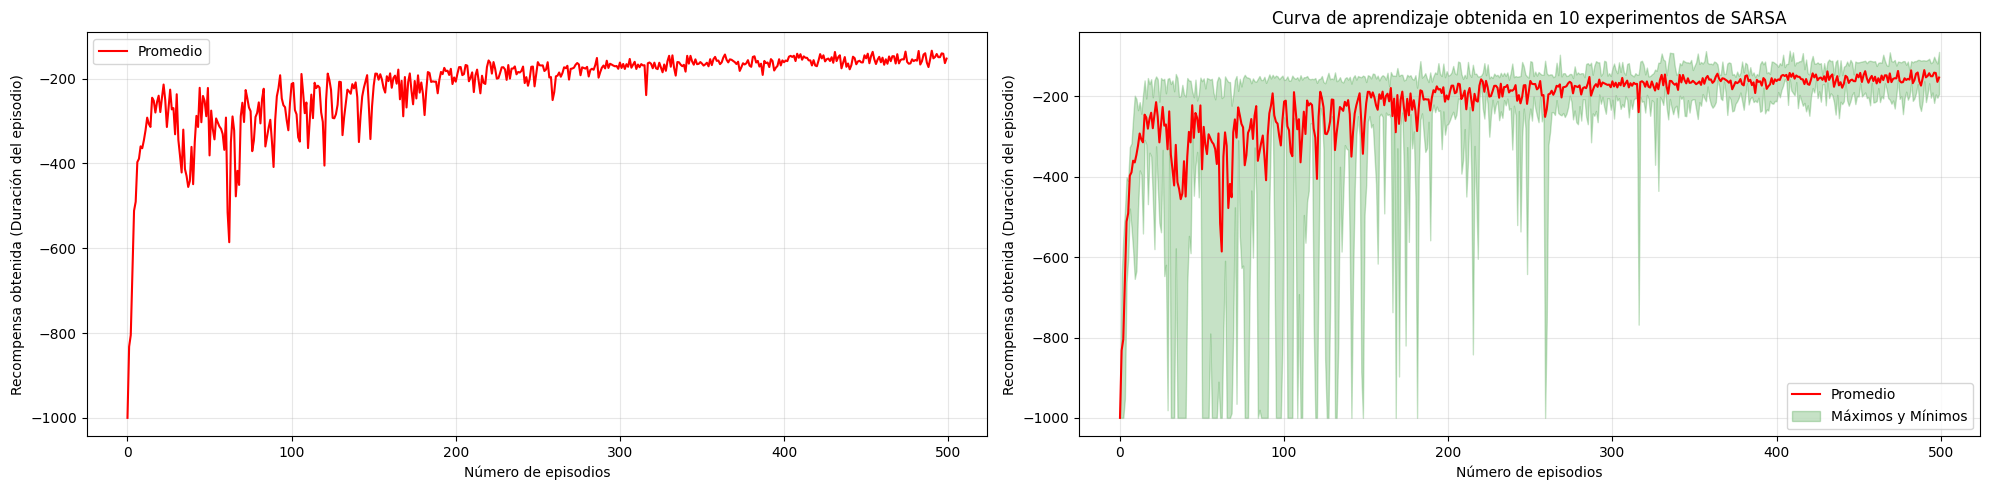

In [ ]:
mean_rewards = np.mean(all_rewards, axis=0)  # Promedio por episodio
min_rewards = np.min(all_rewards, axis=0)  # Mínimo por episodio
max_rewards = np.max(all_rewards, axis=0)  # Máximo por episodio
episodes = np.arange(len(mean_rewards))  # Números de episodios


df = pd.DataFrame({"x": episodes, "min": min_rewards, "max": max_rewards})

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].grid(alpha=0.3)
axs[0].plot(episodes, mean_rewards, color='red', label="Promedio")
axs[0].set_ylabel('Recompensa obtenida (Duración del episodio)')
axs[0].set_xlabel('Número de episodios')
axs[0].legend()
axs[1].grid(alpha=0.3)
axs[1].plot(episodes, mean_rewards, color='red', label="Promedio")
axs[1].fill_between(df["x"], df["min"], df["max"], color='green', alpha=0.225, label="Máximos y Mínimos")
axs[1].set_ylabel('Recompensa obtenida (Duración del episodio)')
axs[1].set_xlabel('Número de episodios')
axs[1].legend()
number_of_experiments = len(all_rewards)
axs[1].set_title(f"Curva de aprendizaje obtenida en {number_of_experiments} experimentos de SARSA")
plt.tight_layout()
plt.show()

In [ ]:
agent.video()

Recompensa obtenida en el episodio: -112.0



Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  97%|█████████▋| 111/114 [00:00<00:00, 123.36it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1743472554.0874107.mp4, 720000 bytes wanted but 0 bytes read,at frame 113/114, at time 3.77/3.77 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


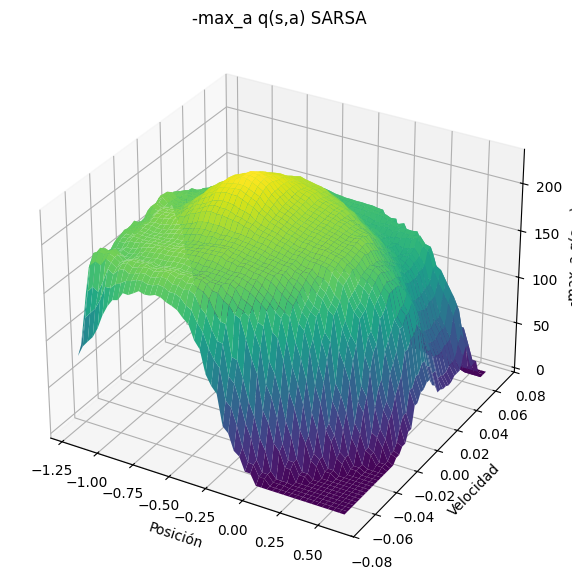

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

pos_range = np.linspace(-1.2, 0.6, 50)
vel_range = np.linspace(-0.07, 0.07, 50)
pos_grid, vel_grid = np.meshgrid(pos_range, vel_range)


Q_values = np.zeros_like(pos_grid)

for i in range(pos_grid.shape[0]):
    for j in range(pos_grid.shape[1]):
        Q_values[i, j] = agent.return_action_value([pos_grid[i, j], vel_grid[i, j]])


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(pos_grid, vel_grid, -Q_values, cmap='viridis')
ax.set_xlabel('Posición')
ax.set_ylabel('Velocidad')
ax.set_zlabel('-max_a q(s, a)')
ax.set_title('-max_a q(s,a) SARSA')

plt.show()


# Reflexiones Finales



# Referencias

[1] Sutton, R. S. and Barto, A. G. (2018). Reinforcement Learning: An Introduction. The MIT Press, second edition.

[2]

[3] Gym Documentation, Mountain Car. `https://gymnasium.farama.org/environments/classic_control/mountain_car/`


[4] keras-rl2 Documentation, SARSA. `https://github.com/inarikami/keras-rl2/blob/master/rl/agents/sarsa.py`